## Cifar_10 CNN

In [1]:
import torch
import numpy as np

# Check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA not available. Training on CPU...')
else:
    print('CUDA is available. Training on GPU...')

CUDA not available. Training on CPU...


In [2]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Number of subprocesses to use for data loading
num_workers = 0

# How many samples per batch to load
batch_size = 20

# Percentage of train data to use as validation
valid_size = 0.2

# Convert data into a normalized torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                               ])

# Choose the training and test data set
train_data = datasets.CIFAR10('data', download=True, train=True, transform=transform)
test_data = datasets.CIFAR10('data', download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loader (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

# Specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

### Visualize a Batch of Training Data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 # Un-normalize
    plt.imshow(np.transpose(img, (1, 2, 0))) # Convert from Tensor image

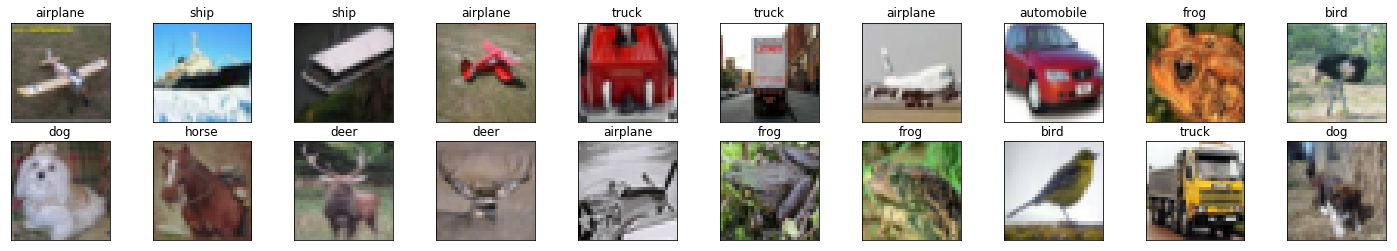

In [5]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Convert images to numpy for display

# Plot the images in the batch along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

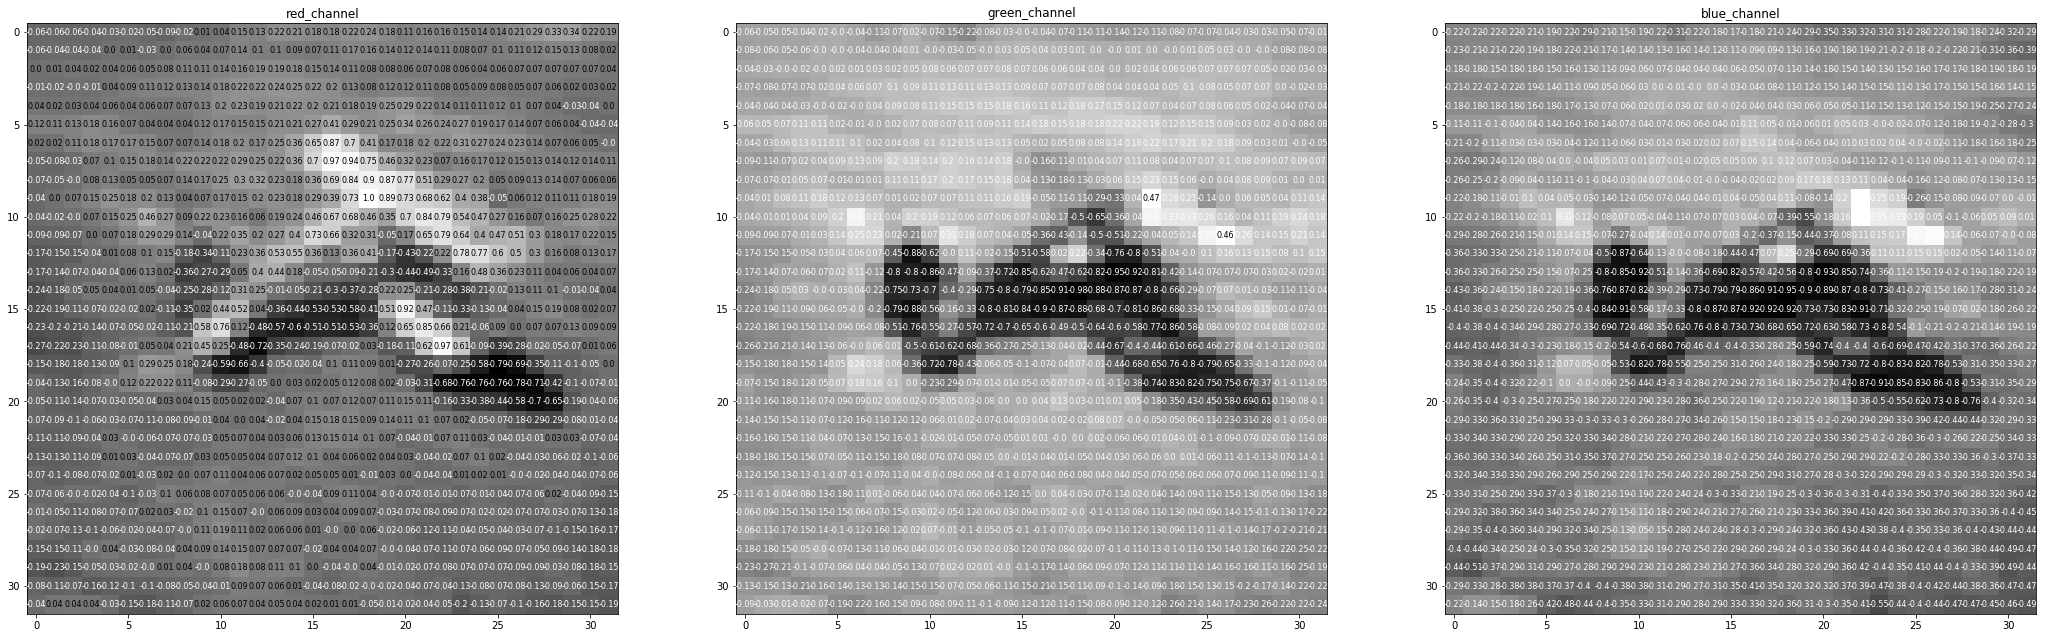

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['red_channel', 'green_channel', 'blue_channel']

fig = plt.figure(figsize=(36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx+1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = idx.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y,x),
                       horizontalalignment='center',
                       verticalalignment='center', size=8,
                       color='white' if img[x][y] < thresh else 'black')

### Define the Network Architecture

In [13]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Convolutional layer
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Linear layer
        self.fcn1 = nn.Linear(64 * 4 * 4, 500)
        self.fcn2 = nn.Linear(500, 10)
        
        # Dropout layer p = 0.25
        self.drop = nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output
        x = x.view(-1, 64*4*4)
        
        # Add the dropout layer
        x = self.drop(x)
        x = F.relu(self.fcn1(x))
        # Add dropout layer
        x = self.drop(x)
        x = self.fcn2(x)
        return x
    
# Create a complete CNN
model = Net()
print(model)

if train_on_gpu:
    message = 'Moving model to cuda GPU...'
    print(message)
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fcn1): Linear(in_features=1024, out_features=500, bias=True)
  (fcn2): Linear(in_features=500, out_features=10, bias=True)
  (drop): Dropout(p=0.25)
)


### Specify loss function and Optimizer

In [19]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Train the Network

In [20]:
# Number of epochs to train the model
epochs = 30

valid_loss_min = np.Inf # Track changes in validation loss

for e in range(1, epochs+1):
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model
    model.train()
    for data, target in train_loader:
        # Move tensors to GPU is cuda is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs into the model
        output = model.forward(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        
        # Update the training loss
        train_loss += loss.item()*data.size(0)
        
    ############################
    #### Validate the model ####
    ############################  
    
    model.eval()
    for data, target in valid_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # Forward pass: compute predicted outputs by passing inputs in the model
        output = model(data)
        
        # Calculate the batch loss
        loss = criterion(output, target)
        
        valid_loss = loss.item()*data.size(0)
        
    
    # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    # Print training/validation statistics
    print('Epoch :{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e, train_loss, valid_loss))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation Loss decreased ({:.6f} ----> {:.6f}). Saving Model...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch :1 	Training Loss: 1.358311 	Validation Loss: 0.000549
Validation Loss decreased (inf ----> 0.000549). Saving Model...
Epoch :2 	Training Loss: 1.180911 	Validation Loss: 0.000475
Validation Loss decreased (0.000549 ----> 0.000475). Saving Model...
Epoch :3 	Training Loss: 1.085715 	Validation Loss: 0.000558
Epoch :4 	Training Loss: 1.006384 	Validation Loss: 0.000306
Validation Loss decreased (0.000475 ----> 0.000306). Saving Model...
Epoch :5 	Training Loss: 0.940626 	Validation Loss: 0.000429
Epoch :6 	Training Loss: 0.877087 	Validation Loss: 0.000434
Epoch :7 	Training Loss: 0.826428 	Validation Loss: 0.000427
Epoch :8 	Training Loss: 0.782367 	Validation Loss: 0.000270
Validation Loss decreased (0.000306 ----> 0.000270). Saving Model...
Epoch :9 	Training Loss: 0.748399 	Validation Loss: 0.000440
Epoch :10 	Training Loss: 0.712162 	Validation Loss: 0.000309
Epoch :11 	Training Loss: 0.680292 	Validation Loss: 0.000416
Epoch :12 	Training Loss: 0.650562 	Validation Loss: 0.0

### Load the Model with the Lowest Validation Loss

In [21]:
model.load_state_dict(torch.load('model_cifar.pt'))

### Test the Trained Network

In [22]:
# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# Iterate over test data
for data, target in test_loader:
    # Move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    # Forward pass: Compute predicted output by passing inputs into the model
    output = model(data)
    # Calculate the batch loss
    loss = criterion(output, target)
    # Update the test loss
    test_loss += loss.item()*data.size(0)
    # Convert output probabilites to predicted class
    _, pred = torch.max(output, 1)
    # Compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu.numpy())
    # Calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# Average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (No Training Examples)' % (classes[i]))
        
print('\n Test Accuracy (Overall) %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.742826

Test Accuracy of airplane: 77% (771/1000)
Test Accuracy of automobile: 84% (845/1000)
Test Accuracy of  bird: 60% (603/1000)
Test Accuracy of   cat: 51% (515/1000)
Test Accuracy of  deer: 72% (729/1000)
Test Accuracy of   dog: 67% (677/1000)
Test Accuracy of  frog: 85% (858/1000)
Test Accuracy of horse: 81% (817/1000)
Test Accuracy of  ship: 84% (849/1000)
Test Accuracy of truck: 86% (868/1000)

 Test Accuracy (Overall) 75% (7532/10000)


### Visualize Sample Test Results

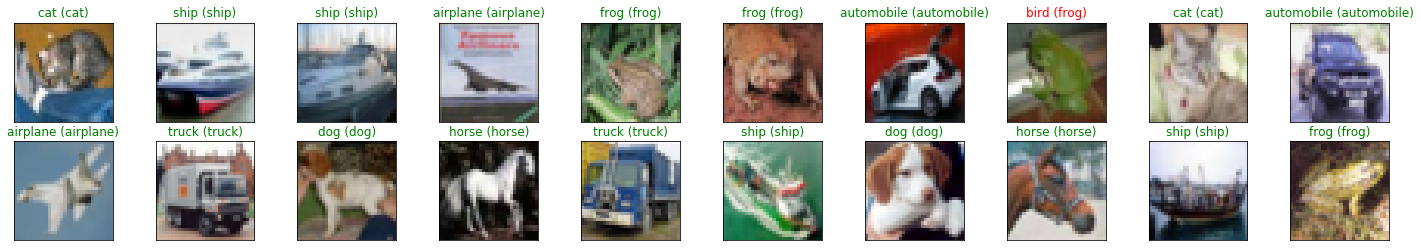

In [23]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))